<a href="https://colab.research.google.com/github/marcoppasini/MelGAN-VC/blob/master/MelGAN_VC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# #We'll be using TF 2.1 and torchaudio

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
!pip install soundfile                    #to save wav files
!pip install --no-deps torchaudio==0.8.1

     |████████████████████████████████| 1.9MB 18.7MB/s 


In [2]:
# !unzip archive.zip

In [3]:
import tensorflow as tf

In [4]:
# mount onto the google drive
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [5]:
# please create these files first if you do not have one
recording_dir = "/content/drive/MyDrive/412-generative-model-main/archive/recordings"
model_dir = "/content/drive/MyDrive/412-generative-model-main/models"
result_dir = "/content/drive/MyDrive/412-generative-model-main/results"

## Spectrogram

In [6]:
#Imports

from __future__ import print_function, division
from glob import glob
import scipy
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate, Conv2D, Conv2DTranspose, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, ReLU, Add, Multiply, Lambda, Dot, BatchNormalization, Activation, ZeroPadding2D, Cropping2D, Cropping1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal, he_normal
import tensorflow.keras.backend as K
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
from PIL import Image
from skimage.transform import resize
import imageio
import librosa
import librosa.display
from librosa.feature import melspectrogram
import os
import time
import IPython

In [7]:
#Hyperparameters

hop=32 # orig: 192               #hop size (window size = 6*hop)
sr=6000 # orig: 16000              #sampling rate
min_level_db=-100     #reference values to normalize data
ref_level_db=20

shape=8 # 原来是24     #length of time axis of split specrograms to feed to generator            
vec_len=64 # orig: 128           #length of vector generated by siamese vector
bs = 16               #batch size
delta = 2.            #constant for siamese loss
# k = 1      # originally = 3

In [8]:
#There seems to be a problem with Tensorflow STFT, so we'll be using pytorch to handle offline mel-spectrogram generation and waveform reconstruction
#For waveform reconstruction, a gradient-based method is used:

''' Decorsière, Rémi, Peter L. Søndergaard, Ewen N. MacDonald, and Torsten Dau. 
"Inversion of auditory spectrograms, traditional spectrograms, and other envelope representations." 
IEEE/ACM Transactions on Audio, Speech, and Language Processing 23, no. 1 (2014): 46-56.'''

#ORIGINAL CODE FROM https://github.com/yoyololicon/spectrogram-inversion

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from functools import partial
import math
import heapq
from torchaudio.transforms import MelScale, Spectrogram

# torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.set_default_tensor_type('torch.FloatTensor')

specobj = Spectrogram(n_fft=6*hop, win_length=6*hop, hop_length=hop, pad=0, power=2, normalized=True)
specfunc = specobj.forward
melobj = MelScale(n_mels=hop, sample_rate=sr, f_min=0.)
melfunc = melobj.forward

def melspecfunc(waveform):
    specgram = specfunc(waveform)
    mel_specgram = melfunc(specgram)
    return mel_specgram

def spectral_convergence(input, target):
    return 20 * ((input - target).norm().log10() - target.norm().log10())

def GRAD(spec, transform_fn, samples=None, init_x0=None, maxiter=1000, tol=1e-6, verbose=1, evaiter=10, lr=0.003):

    spec = torch.Tensor(spec)
    samples = (spec.shape[-1]*hop)-hop

    if init_x0 is None:
        init_x0 = spec.new_empty((1,samples)).normal_(std=1e-6)
    x = nn.Parameter(init_x0)
    T = spec

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam([x], lr=lr)

    bar_dict = {}
    metric_func = spectral_convergence
    bar_dict['spectral_convergence'] = 0
    metric = 'spectral_convergence'

    init_loss = None
    with tqdm(total=maxiter, disable=not verbose) as pbar:
        for i in range(maxiter):
            optimizer.zero_grad()
            V = transform_fn(x)
            loss = criterion(V, T)
            loss.backward()
            optimizer.step()
            lr = lr*0.9999
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

            if i % evaiter == evaiter - 1:
                with torch.no_grad():
                    V = transform_fn(x)
                    bar_dict[metric] = metric_func(V, spec).item()
                    l2_loss = criterion(V, spec).item()
                    pbar.set_postfix(**bar_dict, loss=l2_loss)
                    pbar.update(evaiter)

    return x.detach().view(-1).cpu()

def normalize(S):
    return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1)

def denormalize(S):
    return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db

def prep(wv,hop=32):
    S = np.array(torch.squeeze(melspecfunc(torch.Tensor(wv).view(1,-1))).detach().cpu())
    S = librosa.power_to_db(S)-ref_level_db
    return normalize(S)

def deprep(S):
    S = denormalize(S)+ref_level_db
    S = librosa.db_to_power(S)
    wv = GRAD(np.expand_dims(S,0), melspecfunc, maxiter=2000, evaiter=10, tol=1e-8)
    return np.array(np.squeeze(wv))

In [9]:
#Helper functions

#Generate spectrograms from waveform array
def tospec(data):
    specs=np.empty(data.shape[0], dtype=object)
    for i in range(data.shape[0]):
        x = data[i]
        S=prep(x)
        S = np.array(S, dtype=np.float32)
        specs[i]=np.expand_dims(S, -1)
    print(specs.shape)
    return specs

#Generate multiple spectrograms with a determined length from single wav file
def tospeclong(path, length=4*16000):
    x, sr = librosa.load(path,sr=16000)
    x,_ = librosa.effects.trim(x)
    loudls = librosa.effects.split(x, top_db=50)
    xls = np.array([])
    for interv in loudls:
        xls = np.concatenate((xls,x[interv[0]:interv[1]]))
    x = xls
    num = x.shape[0]//length
    specs=np.empty(num, dtype=object)
    for i in range(num-1):
        a = x[i*length:(i+1)*length]
        S = prep(a)
        S = np.array(S, dtype=np.float32)
        try:
            sh = S.shape
            specs[i]=S
        except AttributeError:
            print('spectrogram failed')
    print(specs.shape)
    return specs

#Waveform array from path of folder containing wav files, and filter wav files by the name
def audio_array(path, name):
    ls = glob(f'{path}/*.wav')
    # print(ls[0])
    adata = []
    for num in range(10):
        prefix = str(num) + "_" + name # 嘉禾说加了这个
        for i in range(len(ls)):
            if prefix in ls[i] and "_0" not in ls[i]:
                x, sr = tf.audio.decode_wav(tf.io.read_file(ls[i]), 1)
                x = np.array(x, dtype=np.float32)
                adata.append(x)
    return np.array(adata)

#Concatenate spectrograms in array along the time axis
def testass(a):
    but=False
    con = np.array([])
    nim = a.shape[0]
    for i in range(nim):
        im = a[i]
        im = np.squeeze(im)
        if not but:
            con=im
            but=True
        else:
            con = np.concatenate((con,im), axis=1)
    return np.squeeze(con)

#Split spectrograms in chunks with equal size
def splitcut(data):
    ls = []
    mini = 0
    minifinal = 10*shape    # max spectrogram length
    k = 3                                 
    for i in range(data.shape[0]-1):
        if data[i].shape[1]<=data[i+1].shape[1]:
            mini = data[i].shape[1]
        else:
            mini = data[i+1].shape[1]
        if mini>=k*shape and mini<minifinal:
            minifinal = mini
    print(minifinal)
    for i in range(data.shape[0]):
        x = data[i]
        if x.shape[1]>=k*shape:
            for n in range(x.shape[1]//minifinal):
                ls.append(x[:,n*minifinal:n*minifinal+minifinal,:])
            ls.append(x[:,-minifinal:,:])
    return np.array(ls)

In [10]:
#Generating Mel-Spectrogram dataset (Uncomment where needed)
#adata: source spectrograms
#bdata: target spectrograms

#MALE1                         
awv = audio_array(recording_dir, "george")                #get waveform array from folder containing wav files
aspec = tospec(awv)                                                 #get spectrogram array
adata = splitcut(aspec)                                             #split spectrogams to fixed length
# print(adata)

#MALE2
bwv = audio_array(recording_dir, "lucas")
bspec = tospec(bwv)
bdata = splitcut(bspec)
# print(bdata)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(490,)
44
(490,)
62


In [11]:
# # test shape correctness
# for i in range(adata.shape[0]-1):
#         if adata[i].shape[1] != 3 * shape:
#             print(i, adata[i].shape[1])

In [12]:
#Creating Tensorflow Datasets

@tf.function
def proc(x):
    return tf.image.random_crop(x, size=[hop, 3*shape, 1])
    # return tf.image.random_crop(x, size=[hop, shape, 1])

# .map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE)
xa = tf.data.Dataset.from_tensor_slices(adata).repeat(50).map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dsa = xa.shuffle(10000).batch(bs, drop_remainder=True)

xb = tf.data.Dataset.from_tensor_slices(bdata).repeat(50).map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dsb = xb.shuffle(10000).batch(bs, drop_remainder=True)

In [13]:
dsb

<BatchDataset shapes: (16, 32, 24, 1), types: tf.float32>

## MelGAN Training

In [14]:
#Adding Spectral Normalization to convolutional layers

from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.eager import context
from tensorflow.python.framework import tensor_shape

def l2normalize(v, eps=1e-12):
    return v / (tf.norm(v) + eps)


class ConvSN2D(tf.keras.layers.Conv2D):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2D, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2D, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar


    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        outputs = self._convolution_op(inputs, new_kernel)

        if self.use_bias:
            if self.data_format == 'channels_first':
                    outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
            else:
                outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')
        if self.activation is not None:
            return self.activation(outputs)

        return outputs

class ConvSN2DTranspose(tf.keras.layers.Conv2DTranspose):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2DTranspose, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2DTranspose, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar

    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)

        inputs_shape = array_ops.shape(inputs)
        batch_size = inputs_shape[0]
        if self.data_format == 'channels_first':
          h_axis, w_axis = 2, 3
        else:
          h_axis, w_axis = 1, 2

        height, width = inputs_shape[h_axis], inputs_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides

        if self.output_padding is None:
          out_pad_h = out_pad_w = None
        else:
          out_pad_h, out_pad_w = self.output_padding

        out_height = conv_utils.deconv_output_length(height,
                                                    kernel_h,
                                                    padding=self.padding,
                                                    output_padding=out_pad_h,
                                                    stride=stride_h,
                                                    dilation=self.dilation_rate[0])
        out_width = conv_utils.deconv_output_length(width,
                                                    kernel_w,
                                                    padding=self.padding,
                                                    output_padding=out_pad_w,
                                                    stride=stride_w,
                                                    dilation=self.dilation_rate[1])
        if self.data_format == 'channels_first':
          output_shape = (batch_size, self.filters, out_height, out_width)
        else:
          output_shape = (batch_size, out_height, out_width, self.filters)

        output_shape_tensor = array_ops.stack(output_shape)
        outputs = K.conv2d_transpose(
            inputs,
            new_kernel,
            output_shape_tensor,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if not context.executing_eagerly():
          out_shape = self.compute_output_shape(inputs.shape)
          outputs.set_shape(out_shape)

        if self.use_bias:
          outputs = tf.nn.bias_add(
              outputs,
              self.bias,
              data_format=conv_utils.convert_data_format(self.data_format, ndim=4))

        if self.activation is not None:
          return self.activation(outputs)
        return outputs  

class DenseSN(Dense):
    def build(self, input_shape):
        super(DenseSN, self).build(input_shape)

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False)
        
    def compute_spectral_norm(self, W, new_u, W_shape):
        new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
        new_u = l2normalize(tf.matmul(new_v, W))
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma
        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)
        return W_bar
        
    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        rank = len(inputs.shape)
        if rank > 2:
          outputs = standard_ops.tensordot(inputs, new_kernel, [[rank - 1], [0]])
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [self.units]
            outputs.set_shape(output_shape)
        else:
          inputs = math_ops.cast(inputs, self._compute_dtype)
          if K.is_sparse(inputs):
            outputs = sparse_ops.sparse_tensor_dense_matmul(inputs, new_kernel)
          else:
            outputs = gen_math_ops.mat_mul(inputs, new_kernel)
        if self.use_bias:
          outputs = tf.nn.bias_add(outputs, self.bias)
        if self.activation is not None:
          return self.activation(outputs)
        return outputs


In [15]:
#Networks Architecture

init = tf.keras.initializers.he_uniform()

def conv2d(layer_input, filters, kernel_size=4, strides=2, padding='same', leaky=True, bnorm=True, sn=True):
  if leaky:
    Activ = LeakyReLU(alpha=0.2)
  else:
    Activ = ReLU()
  if sn:
    d = ConvSN2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  else:
    d = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  if bnorm:
    d = BatchNormalization()(d)
  d = Activ(d)
  return d

def deconv2d(layer_input, layer_res, filters, kernel_size=4, conc=True, scalev=False, bnorm=True, up=True, padding='same', strides=2):
  if up:
    u = UpSampling2D((1,2))(layer_input)
    u = ConvSN2D(filters, kernel_size, strides=(1,1), kernel_initializer=init, use_bias=False, padding=padding)(u)
  else:
    u = ConvSN2DTranspose(filters, kernel_size, strides=strides, kernel_initializer=init, use_bias=False, padding=padding)(layer_input)
  if bnorm:
    u = BatchNormalization()(u)
  u = LeakyReLU(alpha=0.2)(u)
  if conc:
    u = Concatenate()([u,layer_res])
  return u

#Extract function: splitting spectrograms
def extract_image(im):
  im1 = Cropping2D(((0,0), (0, 2*(im.shape[2]//3))))(im)
  im2 = Cropping2D(((0,0), (im.shape[2]//3,im.shape[2]//3)))(im)
  im3 = Cropping2D(((0,0), (2*(im.shape[2]//3), 0)))(im)
  return im1,im2,im3

#Assemble function: concatenating spectrograms
def assemble_image(lsim):
  im1,im2,im3 = lsim
  imh = Concatenate(2)([im1,im2,im3])
  return imh

#U-NET style architecture
def build_generator(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  #downscaling
  g0 = tf.keras.layers.ZeroPadding2D((0,1))(inp)
  g1 = conv2d(g0, 256, kernel_size=(h,3), strides=1, padding='valid')
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2))
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2))
  #upscaling
  g4 = deconv2d(g3,g2, 256, kernel_size=(1,7), strides=(1,2))
  g5 = deconv2d(g4,g1, 256, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g6 = ConvSN2DTranspose(1, kernel_size=(h,1), strides=(1,1), kernel_initializer=init, padding='valid', activation='tanh')(g5)
  return Model(inp,g6, name='G')

#Siamese Network
def build_siamese(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  g1 = conv2d(inp, 256, kernel_size=(h,3), strides=1, padding='valid', sn=False)
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2), sn=False)
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2), sn=False)
  g4 = Flatten()(g3)
  g5 = Dense(vec_len)(g4)
  return Model(inp, g5, name='S')

#Discriminator (Critic) Network
def build_critic(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  g1 = conv2d(inp, 512, kernel_size=(h,3), strides=1, padding='valid', bnorm=False)
  g2 = conv2d(g1, 512, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g3 = conv2d(g2, 512, kernel_size=(1,7), strides=(1,2), bnorm=False)
  g4 = Flatten()(g3)
  g4 = DenseSN(1, kernel_initializer=init)(g4)
  return Model(inp, g4, name='C')

In [16]:
#Load past models from path to resume training or test
def load(path):
  gen = build_generator((hop,shape,1))
  siam = build_siamese((hop,shape,1))
  critic = build_critic((hop,3*shape,1))
  gen.load_weights(path+'/gen.h5')
  critic.load_weights(path+'/critic.h5')
  siam.load_weights(path+'/siam.h5')
  return gen,critic,siam

#Build models
def build():
  gen = build_generator((hop,shape,1))
  siam = build_siamese((hop,shape,1))
  critic = build_critic((hop,3*shape,1))                                          #the discriminator accepts as input spectrograms of triple the width of those generated by the generator
  return gen,critic,siam

#Generate a random batch to display current training results
def testgena():
  sw = True
  while sw:
    a = np.random.choice(aspec)
    if a.shape[1]//shape!=1:
      sw=False
  dsa = []
  if a.shape[1]//shape>6:
    num=6
  else:
    num=a.shape[1]//shape
  rn = np.random.randint(a.shape[1]-(num*shape))
  for i in range(num):
    im = a[:,rn+(i*shape):rn+(i*shape)+shape]
    im = np.reshape(im, (im.shape[0],im.shape[1],1))
    dsa.append(im)
  return np.array(dsa, dtype=np.float32)

#Show results mid-training
def save_test_image_full(path):
  a = testgena()
  print(a.shape)
  ab = gen(a, training=False)
  ab = testass(ab)
  a = testass(a)
  abwv = deprep(ab)
  awv = deprep(a)
  sf.write(path+'/new_file.wav', abwv, sr)
  IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
  IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  fig, axs = plt.subplots(ncols=2)
  axs[0].imshow(np.flip(a, -2), cmap=None)
  axs[0].axis('off')
  axs[0].set_title('Source')
  axs[1].imshow(np.flip(ab, -2), cmap=None)
  axs[1].axis('off')
  axs[1].set_title('Generated')
  plt.show()

#Save in training loop
def save_end(epoch,gloss,closs,mloss,n_save=3,save_path=model_dir):                 #use custom save_path (i.e. Drive '../content/drive/My Drive/')
  if epoch % n_save == 0:
    print('Saving...')
    path = f'{save_path}/MELGANVC-{str(gloss)[:9]}-{str(closs)[:9]}-{str(mloss)[:9]}'
    os.mkdir(path)
    gen.save_weights(path+'/gen.h5')
    critic.save_weights(path+'/critic.h5')
    siam.save_weights(path+'/siam.h5')
    save_test_image_full(path)

In [17]:
#Losses

def mae(x,y):
  return tf.reduce_mean(tf.abs(x-y))

def mse(x,y):
  return tf.reduce_mean((x-y)**2)

def loss_travel(sa,sab,sa1,sab1):
  l1 = tf.reduce_mean(((sa-sa1) - (sab-sab1))**2)
  l2 = tf.reduce_mean(tf.reduce_sum(-(tf.nn.l2_normalize(sa-sa1, axis=[-1]) * tf.nn.l2_normalize(sab-sab1, axis=[-1])), axis=-1))
  return l1+l2

def loss_siamese(sa,sa1):
  logits = tf.sqrt(tf.reduce_sum((sa-sa1)**2, axis=-1, keepdims=True))
  return tf.reduce_mean(tf.square(tf.maximum((delta - logits), 0)))

def d_loss_f(fake):
  return tf.reduce_mean(tf.maximum(1 + fake, 0))

def d_loss_r(real):
  return tf.reduce_mean(tf.maximum(1 - real, 0))

def g_loss_f(fake):
  return tf.reduce_mean(- fake)

In [18]:
#Get models and optimizers
def get_networks(shape, load_model=False, path=None):
  if not load_model:
    gen,critic,siam = build()
  else:
    gen,critic,siam = load(path)
  print('Built networks')

  opt_gen = Adam(0.0001, 0.5)
  opt_disc = Adam(0.0001, 0.5)

  return gen,critic,siam, [opt_gen,opt_disc]

#Set learning rate
def update_lr(lr):
  opt_gen.learning_rate = lr
  opt_disc.learning_rate = lr

In [19]:
#Training Functions

#Train Generator, Siamese and Critic
@tf.function
def train_all(a,b):
    #splitting spectrogram in 3 parts
    aa,aa2,aa3 = extract_image(a) 
    bb,bb2,bb3 = extract_image(b)

    with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_disc:

        #translating A to B
        fab = gen(aa, training=True)
        fab2 = gen(aa2, training=True)
        fab3 = gen(aa3, training=True)
        #identity mapping B to B                    COMMENT THESE 3 LINES IF THE IDENTITY LOSS TERM IS NOT NEEDED
        fid = gen(bb, training=True) 
        fid2 = gen(bb2, training=True)
        fid3 = gen(bb3, training=True)
        #concatenate/assemble converted spectrograms
        fabtot = assemble_image([fab,fab2,fab3])

        #feed concatenated spectrograms to critic
        cab = critic(fabtot, training=True)
        cb = critic(b, training=True)
        #feed 2 pairs (A,G(A)) extracted spectrograms to Siamese
        sab = siam(fab, training=True)
        sab2 = siam(fab3, training=True)
        sa = siam(aa, training=True)
        sa2 = siam(aa3, training=True)

        #identity mapping loss
        loss_id = (mae(bb,fid)+mae(bb2,fid2)+mae(bb3,fid3))/3.        #loss_id = 0. IF THE IDENTITY LOSS TERM IS NOT NEEDED
        #travel loss
        loss_m = loss_travel(sa,sab,sa2,sab2)+loss_siamese(sa,sa2)
        #generator and critic losses
        loss_g = g_loss_f(cab)
        loss_dr = d_loss_r(cb)
        loss_df = d_loss_f(cab)
        loss_d = (loss_dr+loss_df)/2.
        #generator+siamese total loss
        lossgtot = loss_g+10.*loss_m+0.5*loss_id        #CHANGE LOSS WEIGHTS HERE  (COMMENT OUT +w*loss_id IF THE IDENTITY LOSS TERM IS NOT NEEDED)

    #computing and applying gradients
    grad_gen = tape_gen.gradient(lossgtot, gen.trainable_variables+siam.trainable_variables)
    opt_gen.apply_gradients(zip(grad_gen, gen.trainable_variables+siam.trainable_variables))

    grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
    opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))

    return loss_dr,loss_df,loss_g,loss_id

#Train Critic only
@tf.function
def train_d(a,b):
    aa,aa2,aa3 = extract_image(a)
    with tf.GradientTape() as tape_disc:

        fab = gen(aa, training=True)
        fab2 = gen(aa2, training=True)
        fab3 = gen(aa3, training=True)
        fabtot = assemble_image([fab,fab2,fab3])

        cab = critic(fabtot, training=True)
        cb = critic(b, training=True)

        loss_dr = d_loss_r(cb)
        loss_df = d_loss_f(cab)

        loss_d = (loss_dr+loss_df)/2.

    grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
    opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))

    return loss_dr,loss_df

In [20]:
#Training Loop

def train(epochs, batch_size=16, lr=0.0001, n_save=6, gupt=5):
  
    update_lr(lr)
    df_list = []
    dr_list = []
    g_list = []
    id_list = []
    c = 0
    g = 0

    for epoch in range(epochs):
        bef = time.time()

        for batchi,(a,b) in enumerate(zip(dsa,dsb)):

            if batchi%gupt==0:
                dloss_t,dloss_f,gloss,idloss = train_all(a,b)
            else:
                dloss_t,dloss_f = train_d(a,b)

            df_list.append(dloss_f)
            dr_list.append(dloss_t)
            g_list.append(gloss)
            id_list.append(idloss)
            c += 1
            g += 1

            if batchi%500==0:
                print(f'[Epoch {epoch}/{epochs}] [Batch {batchi}] [D loss f: {np.mean(df_list[-g:], axis=0)} ', end='')
                print(f'r: {np.mean(dr_list[-g:], axis=0)}] ', end='')
                print(f'[G loss: {np.mean(g_list[-g:], axis=0)}] ', end='')
                print(f'[ID loss: {np.mean(id_list[-g:])}] ', end='')
                print(f'[LR: {lr}]')
                g = 0
            nbatch=batchi

        print(f'Time/Batch {(time.time()-bef)/nbatch}')
        save_end(epoch,np.mean(g_list[-n_save*c:], axis=0),np.mean(df_list[-n_save*c:], axis=0),np.mean(id_list[-n_save*c:], axis=0),n_save=n_save)
        print(f'Mean D loss: {np.mean(df_list[-c:], axis=0)} Mean G loss: {np.mean(g_list[-c:], axis=0)} Mean ID loss: {np.mean(id_list[-c:], axis=0)}')
        c = 0

    return df_list, dr_list, g_list, id_list
                      

# Start Training

In [21]:
#Build models and initialize optimizers

#If load_model=True, specify the path where the models are saved

gen,critic,siam, [opt_gen,opt_disc] = get_networks(shape, load_model=False, path=model_dir)

Built networks


[Epoch 0/20] [Batch 0] [D loss f: 0.9808840751647949 r: 1.0181138515472412] [G loss: 0.019115950912237167] [ID loss: 0.5653578042984009] [LR: 0.0002]
[Epoch 0/20] [Batch 500] [D loss f: 0.3310680091381073 r: 0.48728233575820923] [G loss: 1.3091470003128052] [ID loss: 0.2674916386604309] [LR: 0.0002]
[Epoch 0/20] [Batch 1000] [D loss f: 0.4676353335380554 r: 0.7044106721878052] [G loss: 0.904237687587738] [ID loss: 0.1633514165878296] [LR: 0.0002]
[Epoch 0/20] [Batch 1500] [D loss f: 0.49423375725746155 r: 0.7431682348251343] [G loss: 0.7892531752586365] [ID loss: 0.14512905478477478] [LR: 0.0002]
[Epoch 0/20] [Batch 2000] [D loss f: 0.49390384554862976 r: 0.7445111274719238] [G loss: 0.7515684962272644] [ID loss: 0.13429564237594604] [LR: 0.0002]
[Epoch 0/20] [Batch 2500] [D loss f: 0.5445241332054138 r: 0.7142319083213806] [G loss: 0.6243155002593994] [ID loss: 0.12832364439964294] [LR: 0.0002]
[Epoch 0/20] [Batch 3000] [D loss f: 0.598111093044281 r: 0.7088846564292908] [G loss: 0.58

  3%|▎         | 60/2000 [00:00<00:03, 532.64it/s, loss=0.00334, spectral_convergence=-7.92]

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:02<00:00, 753.97it/s, loss=0.000276, spectral_convergence=-28.3]


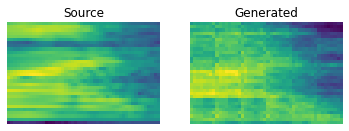

Mean D loss: 0.5500576496124268 Mean G loss: 0.7067875266075134 Mean ID loss: 0.14778536558151245
[Epoch 1/20] [Batch 0] [D loss f: 0.7101349234580994 r: 0.6560272574424744] [G loss: 0.4081893563270569] [ID loss: 0.1190156638622284] [LR: 0.0002]
[Epoch 1/20] [Batch 500] [D loss f: 0.7288742661476135 r: 0.6408241987228394] [G loss: 0.3804692029953003] [ID loss: 0.11742667853832245] [LR: 0.0002]
[Epoch 1/20] [Batch 1000] [D loss f: 0.7368663549423218 r: 0.6403615474700928] [G loss: 0.3794141411781311] [ID loss: 0.11830000579357147] [LR: 0.0002]
[Epoch 1/20] [Batch 1500] [D loss f: 0.7574394345283508 r: 0.6224703192710876] [G loss: 0.35303768515586853] [ID loss: 0.11664339154958725] [LR: 0.0002]
[Epoch 1/20] [Batch 2000] [D loss f: 0.7792033553123474 r: 0.6216195225715637] [G loss: 0.30401700735092163] [ID loss: 0.1166730672121048] [LR: 0.0002]
[Epoch 1/20] [Batch 2500] [D loss f: 0.7873008251190186 r: 0.6124876737594604] [G loss: 0.3135257065296173] [ID loss: 0.11737576127052307] [LR: 0.

  6%|▌         | 120/2000 [00:00<00:02, 776.67it/s, loss=0.000182, spectral_convergence=-12.2]

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:02<00:00, 701.76it/s, loss=8.57e-5, spectral_convergence=-37.3]


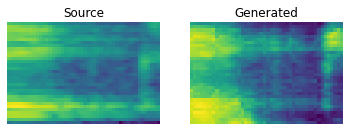

Mean D loss: 0.7644397616386414 Mean G loss: 0.33319857716560364 Mean ID loss: 0.11764663457870483
[Epoch 2/20] [Batch 0] [D loss f: 0.7599439024925232 r: 0.6388927698135376] [G loss: 0.31390246748924255] [ID loss: 0.11828705668449402] [LR: 0.0002]
[Epoch 2/20] [Batch 500] [D loss f: 0.752589225769043 r: 0.6356263756752014] [G loss: 0.34462377429008484] [ID loss: 0.11797663569450378] [LR: 0.0002]
[Epoch 2/20] [Batch 1000] [D loss f: 0.7413308024406433 r: 0.6218456029891968] [G loss: 0.35865262150764465] [ID loss: 0.11604011803865433] [LR: 0.0002]
[Epoch 2/20] [Batch 1500] [D loss f: 0.7291340231895447 r: 0.6390045881271362] [G loss: 0.3676929175853729] [ID loss: 0.1146475076675415] [LR: 0.0002]
[Epoch 2/20] [Batch 2000] [D loss f: 0.7430248856544495 r: 0.6348260641098022] [G loss: 0.34881591796875] [ID loss: 0.11585282534360886] [LR: 0.0002]
[Epoch 2/20] [Batch 2500] [D loss f: 0.7217795848846436 r: 0.6438759565353394] [G loss: 0.3747641444206238] [ID loss: 0.11420036107301712] [LR: 0.

  6%|▌         | 120/2000 [00:00<00:02, 749.29it/s, loss=2.38e-5, spectral_convergence=-6.11]

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:02<00:00, 698.28it/s, loss=1.02e-5, spectral_convergence=-37.9]


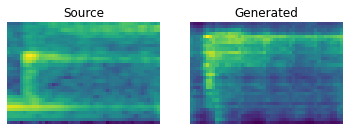

Mean D loss: 0.7270180583000183 Mean G loss: 0.3641304671764374 Mean ID loss: 0.11495798081159592
[Epoch 3/20] [Batch 0] [D loss f: 0.710571825504303 r: 0.6754213571548462] [G loss: 0.36493900418281555] [ID loss: 0.11245343834161758] [LR: 0.0002]
[Epoch 3/20] [Batch 500] [D loss f: 0.7024572491645813 r: 0.6797724962234497] [G loss: 0.38758358359336853] [ID loss: 0.10885587334632874] [LR: 0.0002]
[Epoch 3/20] [Batch 1000] [D loss f: 0.6962236762046814 r: 0.6660886406898499] [G loss: 0.4125966727733612] [ID loss: 0.11587582528591156] [LR: 0.0002]
[Epoch 3/20] [Batch 1500] [D loss f: 0.6943109035491943 r: 0.7039251923561096] [G loss: 0.38972052931785583] [ID loss: 0.11065259575843811] [LR: 0.0002]
[Epoch 3/20] [Batch 2000] [D loss f: 0.7031474709510803 r: 0.6985529661178589] [G loss: 0.3961643576622009] [ID loss: 0.10816068947315216] [LR: 0.0002]
[Epoch 3/20] [Batch 2500] [D loss f: 0.6851119995117188 r: 0.7182433009147644] [G loss: 0.3800787627696991] [ID loss: 0.10899312049150467] [LR: 

  6%|▌         | 110/2000 [00:00<00:02, 746.92it/s, loss=0.0066, spectral_convergence=-8.56] 

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:02<00:00, 686.41it/s, loss=0.000409, spectral_convergence=-28.7]


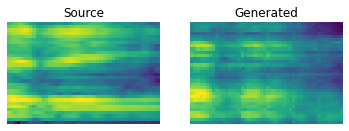

Mean D loss: 0.6953255534172058 Mean G loss: 0.39318010210990906 Mean ID loss: 0.10965157300233841
[Epoch 4/20] [Batch 0] [D loss f: 0.7042015194892883 r: 0.7187435030937195] [G loss: 0.3965494930744171] [ID loss: 0.10814270377159119] [LR: 0.0002]
[Epoch 4/20] [Batch 500] [D loss f: 0.7116434574127197 r: 0.7190585732460022] [G loss: 0.38271307945251465] [ID loss: 0.10796117037534714] [LR: 0.0002]
[Epoch 4/20] [Batch 1000] [D loss f: 0.6854042410850525 r: 0.7283937335014343] [G loss: 0.42205560207366943] [ID loss: 0.1053544357419014] [LR: 0.0002]
[Epoch 4/20] [Batch 1500] [D loss f: 0.7163530588150024 r: 0.7187221050262451] [G loss: 0.3677002191543579] [ID loss: 0.10736440867185593] [LR: 0.0002]
[Epoch 4/20] [Batch 2000] [D loss f: 0.6872962713241577 r: 0.7281638979911804] [G loss: 0.39119842648506165] [ID loss: 0.10825271904468536] [LR: 0.0002]
[Epoch 4/20] [Batch 2500] [D loss f: 0.7071047425270081 r: 0.7247109413146973] [G loss: 0.3755795955657959] [ID loss: 0.10867106169462204] [LR:

  6%|▌         | 120/2000 [00:00<00:02, 798.88it/s, loss=0.00278, spectral_convergence=-11.7]

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:02<00:00, 688.24it/s, loss=0.000342, spectral_convergence=-33.9]


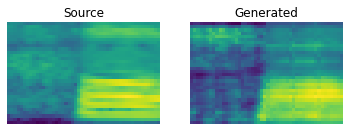

Mean D loss: 0.7010560631752014 Mean G loss: 0.3826192319393158 Mean ID loss: 0.10732308775186539
[Epoch 5/20] [Batch 0] [D loss f: 0.7076371312141418 r: 0.7246680855751038] [G loss: 0.3449535667896271] [ID loss: 0.10600391030311584] [LR: 0.0002]
[Epoch 5/20] [Batch 500] [D loss f: 0.7166049480438232 r: 0.7173781991004944] [G loss: 0.3659031391143799] [ID loss: 0.10390804708003998] [LR: 0.0002]
[Epoch 5/20] [Batch 1000] [D loss f: 0.6926127672195435 r: 0.7368232607841492] [G loss: 0.4010767340660095] [ID loss: 0.10749160498380661] [LR: 0.0002]
[Epoch 5/20] [Batch 1500] [D loss f: 0.7107722163200378 r: 0.7375268936157227] [G loss: 0.36226001381874084] [ID loss: 0.10313941538333893] [LR: 0.0002]
[Epoch 5/20] [Batch 2000] [D loss f: 0.7103903889656067 r: 0.7441492080688477] [G loss: 0.3522762954235077] [ID loss: 0.10290376096963882] [LR: 0.0002]
[Epoch 5/20] [Batch 2500] [D loss f: 0.7098451256752014 r: 0.7405939102172852] [G loss: 0.34701985120773315] [ID loss: 0.10417632758617401] [LR: 

  6%|▌         | 110/2000 [00:00<00:02, 757.98it/s, loss=0.000356, spectral_convergence=-12.6]

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:03<00:00, 653.69it/s, loss=9.12e-5, spectral_convergence=-30]


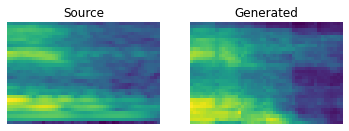

Mean D loss: 0.7097336649894714 Mean G loss: 0.3639783561229706 Mean ID loss: 0.10405189543962479
[Epoch 6/20] [Batch 0] [D loss f: 0.7128145098686218 r: 0.7241921424865723] [G loss: 0.3660319149494171] [ID loss: 0.10311421751976013] [LR: 0.0002]
[Epoch 6/20] [Batch 500] [D loss f: 0.713491678237915 r: 0.7346790432929993] [G loss: 0.3575226962566376] [ID loss: 0.10371403396129608] [LR: 0.0002]
[Epoch 6/20] [Batch 1000] [D loss f: 0.729216456413269 r: 0.7268882989883423] [G loss: 0.3557904064655304] [ID loss: 0.10226063430309296] [LR: 0.0002]
[Epoch 6/20] [Batch 1500] [D loss f: 0.734308660030365 r: 0.7098625302314758] [G loss: 0.34857073426246643] [ID loss: 0.10357441753149033] [LR: 0.0002]
[Epoch 6/20] [Batch 2000] [D loss f: 0.7356559634208679 r: 0.7247116565704346] [G loss: 0.32285186648368835] [ID loss: 0.10290946811437607] [LR: 0.0002]
[Epoch 6/20] [Batch 2500] [D loss f: 0.7409813404083252 r: 0.7331865429878235] [G loss: 0.32064342498779297] [ID loss: 0.10199014842510223] [LR: 0.

  6%|▌         | 110/2000 [00:00<00:02, 730.57it/s, loss=0.00175, spectral_convergence=-14] 

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:02<00:00, 670.46it/s, loss=0.000225, spectral_convergence=-27.6]


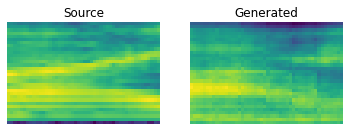

Mean D loss: 0.7292696833610535 Mean G loss: 0.34072819352149963 Mean ID loss: 0.10256028175354004
[Epoch 7/20] [Batch 0] [D loss f: 0.7383832931518555 r: 0.7311570644378662] [G loss: 0.31588512659072876] [ID loss: 0.10386884212493896] [LR: 0.0002]
[Epoch 7/20] [Batch 500] [D loss f: 0.7330149412155151 r: 0.7323641180992126] [G loss: 0.3047211766242981] [ID loss: 0.10237561166286469] [LR: 0.0002]
[Epoch 7/20] [Batch 1000] [D loss f: 0.7493976950645447 r: 0.7268937826156616] [G loss: 0.31160932779312134] [ID loss: 0.10269845277070999] [LR: 0.0002]
[Epoch 7/20] [Batch 1500] [D loss f: 0.7415035963058472 r: 0.7332037091255188] [G loss: 0.3300963044166565] [ID loss: 0.1011749878525734] [LR: 0.0002]
[Epoch 7/20] [Batch 2000] [D loss f: 0.7534498572349548 r: 0.7168042063713074] [G loss: 0.317495733499527] [ID loss: 0.1007569283246994] [LR: 0.0002]
[Epoch 7/20] [Batch 2500] [D loss f: 0.7512454986572266 r: 0.7259930372238159] [G loss: 0.30186727643013] [ID loss: 0.10468736290931702] [LR: 0.00

  6%|▌         | 110/2000 [00:00<00:02, 738.10it/s, loss=0.000475, spectral_convergence=-13.3]

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:02<00:00, 668.57it/s, loss=0.000148, spectral_convergence=-41.6]


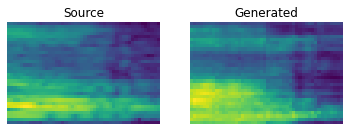

Mean D loss: 0.7437640428543091 Mean G loss: 0.3137301802635193 Mean ID loss: 0.10119300335645676
[Epoch 8/20] [Batch 0] [D loss f: 0.7358425855636597 r: 0.7320985198020935] [G loss: 0.335748553276062] [ID loss: 0.09996306896209717] [LR: 0.0002]
[Epoch 8/20] [Batch 500] [D loss f: 0.7452383041381836 r: 0.7465856075286865] [G loss: 0.3043830096721649] [ID loss: 0.09982554614543915] [LR: 0.0002]
[Epoch 8/20] [Batch 1000] [D loss f: 0.7232505679130554 r: 0.7562872171401978] [G loss: 0.35377028584480286] [ID loss: 0.09723612666130066] [LR: 0.0002]
[Epoch 8/20] [Batch 1500] [D loss f: 0.7563159465789795 r: 0.7346625924110413] [G loss: 0.29430046677589417] [ID loss: 0.09568057209253311] [LR: 0.0002]
[Epoch 8/20] [Batch 2000] [D loss f: 0.7510290741920471 r: 0.7490440607070923] [G loss: 0.3070555329322815] [ID loss: 0.09943985193967819] [LR: 0.0002]
[Epoch 8/20] [Batch 2500] [D loss f: 0.7464367747306824 r: 0.7562747001647949] [G loss: 0.3093721866607666] [ID loss: 0.09661193192005157] [LR: 0

  6%|▌         | 110/2000 [00:00<00:02, 697.27it/s, loss=0.00128, spectral_convergence=-11.3]

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:03<00:00, 660.41it/s, loss=9.29e-5, spectral_convergence=-34.5]


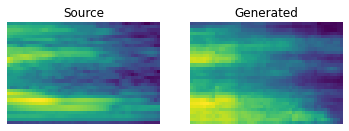

Mean D loss: 0.7449053525924683 Mean G loss: 0.31055203080177307 Mean ID loss: 0.0978134274482727
[Epoch 9/20] [Batch 0] [D loss f: 0.7384606599807739 r: 0.7503552436828613] [G loss: 0.31497669219970703] [ID loss: 0.10022726655006409] [LR: 0.0002]
[Epoch 9/20] [Batch 500] [D loss f: 0.7602953910827637 r: 0.7346292734146118] [G loss: 0.30260536074638367] [ID loss: 0.09694664180278778] [LR: 0.0002]
[Epoch 9/20] [Batch 1000] [D loss f: 0.7504324913024902 r: 0.7512274384498596] [G loss: 0.2858797311782837] [ID loss: 0.09802582114934921] [LR: 0.0002]
[Epoch 9/20] [Batch 1500] [D loss f: 0.7290036678314209 r: 0.7518275380134583] [G loss: 0.3283926248550415] [ID loss: 0.09760897606611252] [LR: 0.0002]
[Epoch 9/20] [Batch 2000] [D loss f: 0.7451213002204895 r: 0.7417669892311096] [G loss: 0.30968180298805237] [ID loss: 0.0964541807770729] [LR: 0.0002]
[Epoch 9/20] [Batch 2500] [D loss f: 0.7483409643173218 r: 0.7395616769790649] [G loss: 0.29941412806510925] [ID loss: 0.0975838378071785] [LR: 

  6%|▌         | 110/2000 [00:00<00:02, 689.92it/s, loss=0.0144, spectral_convergence=-9.05]

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:03<00:00, 644.37it/s, loss=0.000396, spectral_convergence=-32]


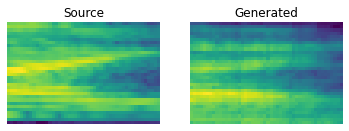

Mean D loss: 0.7488959431648254 Mean G loss: 0.3020271956920624 Mean ID loss: 0.09647377580404282
[Epoch 10/20] [Batch 0] [D loss f: 0.7476688027381897 r: 0.7551006078720093] [G loss: 0.2935597896575928] [ID loss: 0.09406409412622452] [LR: 0.0002]
[Epoch 10/20] [Batch 500] [D loss f: 0.7461256980895996 r: 0.7526764869689941] [G loss: 0.3081439137458801] [ID loss: 0.09442831575870514] [LR: 0.0002]
[Epoch 10/20] [Batch 1000] [D loss f: 0.7578765749931335 r: 0.7483656406402588] [G loss: 0.28383874893188477] [ID loss: 0.09371166676282883] [LR: 0.0002]
[Epoch 10/20] [Batch 1500] [D loss f: 0.7507569789886475 r: 0.7501456141471863] [G loss: 0.28711825609207153] [ID loss: 0.09474058449268341] [LR: 0.0002]
[Epoch 10/20] [Batch 2000] [D loss f: 0.7586591839790344 r: 0.7488371729850769] [G loss: 0.2863682210445404] [ID loss: 0.09434843808412552] [LR: 0.0002]
[Epoch 10/20] [Batch 2500] [D loss f: 0.7424193024635315 r: 0.7504875659942627] [G loss: 0.31757551431655884] [ID loss: 0.0967475175857544]

  6%|▌         | 110/2000 [00:00<00:02, 649.20it/s, loss=0.0155, spectral_convergence=-8.1] 

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:03<00:00, 654.05it/s, loss=0.000947, spectral_convergence=-21.4]


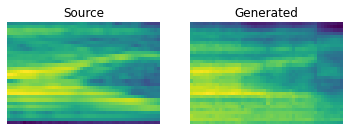

Mean D loss: 0.7540556788444519 Mean G loss: 0.2908470928668976 Mean ID loss: 0.09527716040611267
[Epoch 11/20] [Batch 0] [D loss f: 0.7452000379562378 r: 0.7578535079956055] [G loss: 0.2897133529186249] [ID loss: 0.09676679223775864] [LR: 0.0002]
[Epoch 11/20] [Batch 500] [D loss f: 0.7625528573989868 r: 0.7626996040344238] [G loss: 0.27651724219322205] [ID loss: 0.0913788452744484] [LR: 0.0002]
[Epoch 11/20] [Batch 1000] [D loss f: 0.7627447247505188 r: 0.7499417662620544] [G loss: 0.27842724323272705] [ID loss: 0.09581321477890015] [LR: 0.0002]
[Epoch 11/20] [Batch 1500] [D loss f: 0.7372996211051941 r: 0.7616236805915833] [G loss: 0.306709349155426] [ID loss: 0.0927296131849289] [LR: 0.0002]
[Epoch 11/20] [Batch 2000] [D loss f: 0.7711470723152161 r: 0.7462573051452637] [G loss: 0.266993910074234] [ID loss: 0.09304554015398026] [LR: 0.0002]
[Epoch 11/20] [Batch 2500] [D loss f: 0.7531696557998657 r: 0.7514148950576782] [G loss: 0.2955811619758606] [ID loss: 0.09528343379497528] [LR

  5%|▌         | 100/2000 [00:00<00:02, 662.31it/s, loss=0.000438, spectral_convergence=-13.1]

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:03<00:00, 642.37it/s, loss=3.73e-5, spectral_convergence=-33.4]


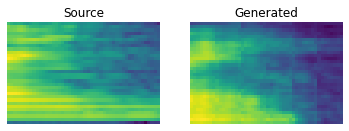

Mean D loss: 0.7575929760932922 Mean G loss: 0.2857871949672699 Mean ID loss: 0.09296371042728424
[Epoch 12/20] [Batch 0] [D loss f: 0.747660219669342 r: 0.7571327686309814] [G loss: 0.30269670486450195] [ID loss: 0.09067387133836746] [LR: 0.0002]
[Epoch 12/20] [Batch 500] [D loss f: 0.7566454410552979 r: 0.7445938587188721] [G loss: 0.26980090141296387] [ID loss: 0.09329777210950851] [LR: 0.0002]
[Epoch 12/20] [Batch 1000] [D loss f: 0.7342404723167419 r: 0.7803075313568115] [G loss: 0.3085663318634033] [ID loss: 0.09133435040712357] [LR: 0.0002]
[Epoch 12/20] [Batch 1500] [D loss f: 0.7646817564964294 r: 0.7502471804618835] [G loss: 0.27464354038238525] [ID loss: 0.09094437956809998] [LR: 0.0002]
[Epoch 12/20] [Batch 2000] [D loss f: 0.7724432349205017 r: 0.7500087022781372] [G loss: 0.26351794600486755] [ID loss: 0.09333604574203491] [LR: 0.0002]
[Epoch 12/20] [Batch 2500] [D loss f: 0.7616771459579468 r: 0.7650134563446045] [G loss: 0.28560349345207214] [ID loss: 0.0911325216293335

  6%|▌         | 110/2000 [00:00<00:02, 709.65it/s, loss=0.00179, spectral_convergence=-11]  

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:03<00:00, 654.15it/s, loss=5.41e-5, spectral_convergence=-36]


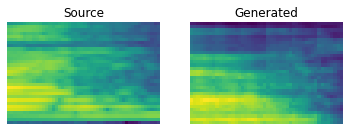

Mean D loss: 0.7601117491722107 Mean G loss: 0.2810131013393402 Mean ID loss: 0.09183254837989807
[Epoch 13/20] [Batch 0] [D loss f: 0.7698466181755066 r: 0.7627612948417664] [G loss: 0.28280308842658997] [ID loss: 0.0920085459947586] [LR: 0.0002]
[Epoch 13/20] [Batch 500] [D loss f: 0.763467013835907 r: 0.7682530283927917] [G loss: 0.26923367381095886] [ID loss: 0.09041424840688705] [LR: 0.0002]
[Epoch 13/20] [Batch 1000] [D loss f: 0.7755579948425293 r: 0.7473028898239136] [G loss: 0.2605966627597809] [ID loss: 0.09047578275203705] [LR: 0.0002]
[Epoch 13/20] [Batch 1500] [D loss f: 0.7722564935684204 r: 0.7578006386756897] [G loss: 0.26645684242248535] [ID loss: 0.08973424136638641] [LR: 0.0002]
[Epoch 13/20] [Batch 2000] [D loss f: 0.7556117177009583 r: 0.7740122079849243] [G loss: 0.28660285472869873] [ID loss: 0.08876989781856537] [LR: 0.0002]
[Epoch 13/20] [Batch 2500] [D loss f: 0.7511867880821228 r: 0.7807934284210205] [G loss: 0.29055413603782654] [ID loss: 0.08672680705785751

  6%|▌         | 110/2000 [00:00<00:02, 650.77it/s, loss=0.000596, spectral_convergence=-15.2]

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:03<00:00, 638.82it/s, loss=9.47e-5, spectral_convergence=-36.1]


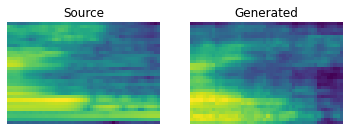

Mean D loss: 0.7655463218688965 Mean G loss: 0.2723926305770874 Mean ID loss: 0.0894661545753479
[Epoch 14/20] [Batch 0] [D loss f: 0.7684556245803833 r: 0.771895706653595] [G loss: 0.27008724212646484] [ID loss: 0.08998111635446548] [LR: 0.0002]
[Epoch 14/20] [Batch 500] [D loss f: 0.7722072601318359 r: 0.766679048538208] [G loss: 0.2617356777191162] [ID loss: 0.09058605879545212] [LR: 0.0002]
[Epoch 14/20] [Batch 1000] [D loss f: 0.7600277066230774 r: 0.7726051807403564] [G loss: 0.2866470217704773] [ID loss: 0.08960316330194473] [LR: 0.0002]
[Epoch 14/20] [Batch 1500] [D loss f: 0.7532837986946106 r: 0.7812685370445251] [G loss: 0.27561283111572266] [ID loss: 0.09061849117279053] [LR: 0.0002]
[Epoch 14/20] [Batch 2000] [D loss f: 0.7747905254364014 r: 0.7626670002937317] [G loss: 0.2573639750480652] [ID loss: 0.09108038246631622] [LR: 0.0002]
[Epoch 14/20] [Batch 2500] [D loss f: 0.7594991326332092 r: 0.7641889452934265] [G loss: 0.2816672921180725] [ID loss: 0.08722082525491714] [L

  5%|▌         | 100/2000 [00:00<00:02, 676.63it/s, loss=0.000162, spectral_convergence=-13.1]

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:03<00:00, 636.51it/s, loss=0.00117, spectral_convergence=-25.6]


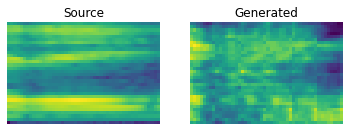

Mean D loss: 0.7674166560173035 Mean G loss: 0.26936233043670654 Mean ID loss: 0.08930297195911407
[Epoch 15/20] [Batch 0] [D loss f: 0.7631142139434814 r: 0.7874613404273987] [G loss: 0.2630771994590759] [ID loss: 0.08651266992092133] [LR: 0.0002]
[Epoch 15/20] [Batch 500] [D loss f: 0.7755484580993652 r: 0.7660171389579773] [G loss: 0.26010578870773315] [ID loss: 0.08985937386751175] [LR: 0.0002]
[Epoch 15/20] [Batch 1000] [D loss f: 0.7620040774345398 r: 0.7886479496955872] [G loss: 0.27226459980010986] [ID loss: 0.0894814133644104] [LR: 0.0002]
[Epoch 15/20] [Batch 1500] [D loss f: 0.7718713283538818 r: 0.7920476198196411] [G loss: 0.2594567835330963] [ID loss: 0.08764013648033142] [LR: 0.0002]
[Epoch 15/20] [Batch 2000] [D loss f: 0.7790215015411377 r: 0.7578531503677368] [G loss: 0.25945764780044556] [ID loss: 0.08683937042951584] [LR: 0.0002]
[Epoch 15/20] [Batch 2500] [D loss f: 0.759315550327301 r: 0.7741004824638367] [G loss: 0.26498138904571533] [ID loss: 0.09069351106882095

  5%|▌         | 100/2000 [00:00<00:03, 621.09it/s, loss=0.000326, spectral_convergence=-15.2]

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:03<00:00, 643.77it/s, loss=0.000362, spectral_convergence=-30.2]


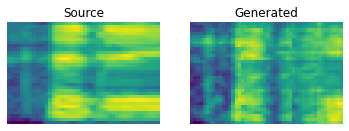

Mean D loss: 0.7677987813949585 Mean G loss: 0.2642078995704651 Mean ID loss: 0.0882163941860199
[Epoch 16/20] [Batch 0] [D loss f: 0.7592872977256775 r: 0.777180016040802] [G loss: 0.2797594964504242] [ID loss: 0.086216039955616] [LR: 0.0002]
[Epoch 16/20] [Batch 500] [D loss f: 0.7591596841812134 r: 0.790889322757721] [G loss: 0.285328209400177] [ID loss: 0.08547220379114151] [LR: 0.0002]
[Epoch 16/20] [Batch 1000] [D loss f: 0.7742581963539124 r: 0.7827814817428589] [G loss: 0.2674247920513153] [ID loss: 0.08643195778131485] [LR: 0.0002]
[Epoch 16/20] [Batch 1500] [D loss f: 0.7749433517456055 r: 0.7756905555725098] [G loss: 0.2548532485961914] [ID loss: 0.08590289205312729] [LR: 0.0002]
[Epoch 16/20] [Batch 2000] [D loss f: 0.7783359289169312 r: 0.7737086415290833] [G loss: 0.2525540590286255] [ID loss: 0.08533581346273422] [LR: 0.0002]
[Epoch 16/20] [Batch 2500] [D loss f: 0.7707739472389221 r: 0.7810463905334473] [G loss: 0.26944372057914734] [ID loss: 0.08572409301996231] [LR: 0

  5%|▌         | 100/2000 [00:00<00:02, 653.57it/s, loss=0.000453, spectral_convergence=-10.5]

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:03<00:00, 646.65it/s, loss=2.59e-5, spectral_convergence=-32.1]


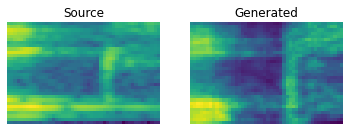

Mean D loss: 0.7725749611854553 Mean G loss: 0.26388147473335266 Mean ID loss: 0.08593184500932693
[Epoch 17/20] [Batch 0] [D loss f: 0.7713871598243713 r: 0.787896990776062] [G loss: 0.2605513036251068] [ID loss: 0.08656122535467148] [LR: 0.0002]
[Epoch 17/20] [Batch 500] [D loss f: 0.7814640402793884 r: 0.7751181721687317] [G loss: 0.25409820675849915] [ID loss: 0.08602298051118851] [LR: 0.0002]
[Epoch 17/20] [Batch 1000] [D loss f: 0.7992025017738342 r: 0.7674974203109741] [G loss: 0.22867101430892944] [ID loss: 0.08610255271196365] [LR: 0.0002]
[Epoch 17/20] [Batch 1500] [D loss f: 0.7806165814399719 r: 0.7826152443885803] [G loss: 0.25566890835762024] [ID loss: 0.08661772310733795] [LR: 0.0002]
[Epoch 17/20] [Batch 2000] [D loss f: 0.776350736618042 r: 0.7875789999961853] [G loss: 0.24863038957118988] [ID loss: 0.08548707515001297] [LR: 0.0002]
[Epoch 17/20] [Batch 2500] [D loss f: 0.771073579788208 r: 0.7942845225334167] [G loss: 0.26643499732017517] [ID loss: 0.08736265450716019

  5%|▌         | 100/2000 [00:00<00:02, 688.59it/s, loss=0.00342, spectral_convergence=-12] 

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:03<00:00, 612.35it/s, loss=0.000332, spectral_convergence=-28.7]


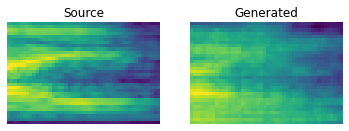

Mean D loss: 0.7810865044593811 Mean G loss: 0.2526932954788208 Mean ID loss: 0.08578501641750336
[Epoch 18/20] [Batch 0] [D loss f: 0.7805406451225281 r: 0.7829480171203613] [G loss: 0.24956780672073364] [ID loss: 0.0854896754026413] [LR: 0.0002]
[Epoch 18/20] [Batch 500] [D loss f: 0.7956596612930298 r: 0.7683801054954529] [G loss: 0.22929419577121735] [ID loss: 0.08273924142122269] [LR: 0.0002]
[Epoch 18/20] [Batch 1000] [D loss f: 0.7766574621200562 r: 0.7836354970932007] [G loss: 0.2613830864429474] [ID loss: 0.0822221040725708] [LR: 0.0002]
[Epoch 18/20] [Batch 1500] [D loss f: 0.793244481086731 r: 0.7785918116569519] [G loss: 0.236799955368042] [ID loss: 0.08324054628610611] [LR: 0.0002]
[Epoch 18/20] [Batch 2000] [D loss f: 0.7928917407989502 r: 0.7806247472763062] [G loss: 0.23836414515972137] [ID loss: 0.08549188077449799] [LR: 0.0002]
[Epoch 18/20] [Batch 2500] [D loss f: 0.7691572904586792 r: 0.7999754548072815] [G loss: 0.26374363899230957] [ID loss: 0.08392788469791412] [

  5%|▌         | 100/2000 [00:00<00:02, 666.67it/s, loss=0.000675, spectral_convergence=-16.4]

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:03<00:00, 614.72it/s, loss=8.49e-5, spectral_convergence=-41.4]


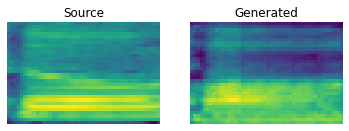

Mean D loss: 0.7877611517906189 Mean G loss: 0.24426256120204926 Mean ID loss: 0.08351054042577744
[Epoch 19/20] [Batch 0] [D loss f: 0.7809786200523376 r: 0.79619961977005] [G loss: 0.2494868040084839] [ID loss: 0.0839628055691719] [LR: 0.0002]
[Epoch 19/20] [Batch 500] [D loss f: 0.7959915995597839 r: 0.774986207485199] [G loss: 0.2396439164876938] [ID loss: 0.08209245651960373] [LR: 0.0002]
[Epoch 19/20] [Batch 1000] [D loss f: 0.8001471757888794 r: 0.7710548043251038] [G loss: 0.23198029398918152] [ID loss: 0.08229947835206985] [LR: 0.0002]
[Epoch 19/20] [Batch 1500] [D loss f: 0.7667564749717712 r: 0.8148626685142517] [G loss: 0.2669047713279724] [ID loss: 0.08360817283391953] [LR: 0.0002]
[Epoch 19/20] [Batch 2000] [D loss f: 0.7896714806556702 r: 0.7880445718765259] [G loss: 0.2417789250612259] [ID loss: 0.08264283835887909] [LR: 0.0002]
[Epoch 19/20] [Batch 2500] [D loss f: 0.7785426378250122 r: 0.7965412139892578] [G loss: 0.24594926834106445] [ID loss: 0.08181904256343842] [L

  5%|▌         | 100/2000 [00:00<00:02, 648.55it/s, loss=0.0118, spectral_convergence=-9.03]

(6, 32, 8, 1)


100%|██████████| 2000/2000 [00:03<00:00, 628.87it/s, loss=0.000341, spectral_convergence=-29.6]


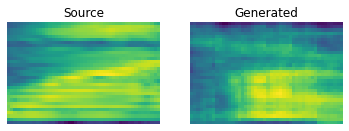

Mean D loss: 0.7881179451942444 Mean G loss: 0.24375320971012115 Mean ID loss: 0.08252425491809845


In [22]:
#Training

#n_save = how many epochs between each saving and displaying of results
#gupt = how many discriminator updates for generator+siamese update

# train(5000, batch_size=bs, lr=0.0002, n_save=1, gupt=3)
df_list, dr_list, g_list, id_list = train(20, batch_size=bs, lr=0.0002, n_save=1, gupt=3)

In [23]:
import matplotlib.pyplot as plt

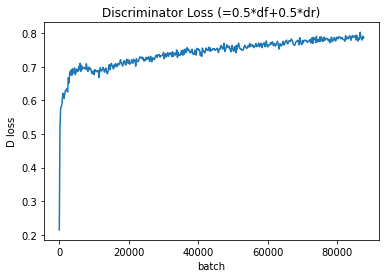

In [24]:
N = len(df_list)
i = 0
dfs = []
pace = 200
while i * pace < N:
    cur_f = df_list[i*pace:(i+1)*pace]
    cur_r = dr_list[i*pace:(i+1)*pace]
    dfs.append(0.5 * np.mean(cur_f) + 0.5 * np.mean(cur_r))
    i += 1

plt.plot(range(1,N,pace), dfs)
plt.title("Discriminator Loss (=0.5*df+0.5*dr)")
plt.xlabel("batch")
plt.ylabel("D loss")
plt.show()

In [25]:
# i = 0
# drs = []
# pace = 200
# while i * pace < N:
#     cur = dr_list[i*pace:(i+1)*pace]
#     drs.append(np.mean(cur))
#     i += 1

# plt.plot(range(1,N,pace), drs)
# plt.title("Discriminator r Loss")
# plt.xlabel("batch")
# plt.ylabel("D f loss")
# plt.show()

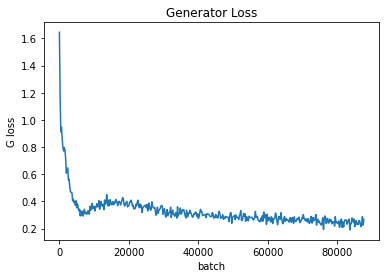

In [26]:
i = 0
gs = []
pace = 200
while i * pace < N:
    cur = g_list[i*pace:(i+1)*pace]
    gs.append(np.mean(cur))
    i += 1
    
plt.plot(range(1,N,pace), gs)
plt.title("Generator Loss")
plt.xlabel("batch")
plt.ylabel("G loss")
plt.show()

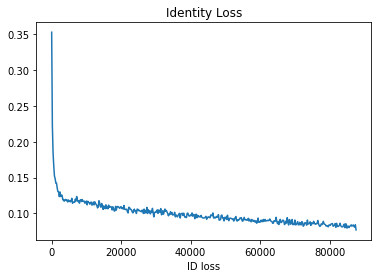

In [27]:
i = 0
ids = []
pace = 200
while i * pace < N:
    cur = id_list[i*pace:(i+1)*pace]
    ids.append(np.mean(cur))
    i += 1
    
plt.plot(range(1,N,pace), ids)
plt.title("Identity Loss")
plt.xlabel("batch")
plt.xlabel("ID loss")
plt.show()

Trails on Test Dataset

In [28]:
#After Training, use these functions to convert data with the generator and save the results

#Assembling generated Spectrogram chunks into final Spectrogram
def specass(a,spec):
    but=False
    con = np.array([])
    nim = a.shape[0]
    for i in range(nim-1):
        im = a[i]
        im = np.squeeze(im)
        if not but:
            con=im
            but=True
        else:
            con = np.concatenate((con,im), axis=1)
    diff = spec.shape[1]-(nim*shape)
    a = np.squeeze(a)
    con = np.concatenate((con,a[-1,:,-diff:]), axis=1)
    return np.squeeze(con)

#Splitting input spectrogram into different chunks to feed to the generator
def chopspec(spec):
    dsa=[]
    for i in range(spec.shape[1]//shape):
        im = spec[:,i*shape:i*shape+shape]
        im = np.reshape(im, (im.shape[0],im.shape[1],1))
        dsa.append(im)
    imlast = spec[:,-shape:]
    imlast = np.reshape(imlast, (imlast.shape[0],imlast.shape[1],1))
    dsa.append(imlast)
    return np.array(dsa, dtype=np.float32)

#Converting from source Spectrogram to target Spectrogram
def towave(spec, name, num, path=model_dir, show=False):
    specarr = chopspec(spec)
    print(specarr.shape)
    a = specarr
    print('Generating...')
    ab = gen(a, training=False)
    print('Assembling and Converting...')
    a = specass(a,spec)
    ab = specass(ab,spec)
    awv = deprep(a)
    abwv = deprep(ab)
    print('Saving...')
    pathfin = f'{path}/{name}'
    if not os.path.exists(pathfin):
        os.mkdir(pathfin)
    sf.write(pathfin+'/generated-' + str(num) + '.wav', abwv, sr)
    sf.write(pathfin+'/source-' + str(num) + '.wav', awv, sr)
    print('Saved WAV!')
    # IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
    # IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
    if show:
        fig, axs = plt.subplots(figsize=(8.0, 2.0), ncols=2)
        axs[0].imshow(np.flip(a, -2), cmap=None)
        axs[0].axis('off')
        axs[0].set_title('Source ' + str(num))
        axs[1].imshow(np.flip(ab, -2), cmap=None)
        axs[1].axis('off')
        axs[1].set_title('Generated ' + str(num))
        plt.savefig(pathfin+"/spectrogram-" + str(num) + ".jpg")
        plt.show()
    return abwv

  2%|▏         | 30/2000 [00:00<00:04, 489.60it/s, loss=0.0138, spectral_convergence=-1.77]

(2384, 1)
(10, 32, 8, 1)
Generating...
Assembling and Converting...


100%|██████████| 2000/2000 [00:02<00:00, 744.90it/s, loss=0.000578, spectral_convergence=-15.6]


Saving...
Saved WAV!


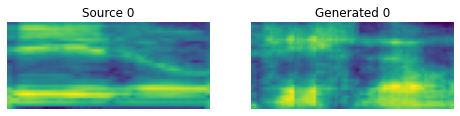

  2%|▏         | 30/2000 [00:00<00:03, 494.02it/s, loss=0.000921, spectral_convergence=-9.39]

(4548, 1)
(18, 32, 8, 1)
Generating...
Assembling and Converting...


100%|██████████| 2000/2000 [00:03<00:00, 587.72it/s, loss=0.000356, spectral_convergence=-18.9]


Saving...
Saved WAV!


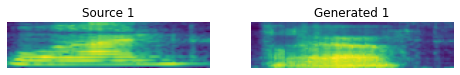

  1%|          | 20/2000 [00:00<00:04, 455.85it/s, loss=0.0109, spectral_convergence=-.647]

(2643, 1)
(11, 32, 8, 1)
Generating...
Assembling and Converting...


100%|██████████| 2000/2000 [00:02<00:00, 680.79it/s, loss=0.00127, spectral_convergence=-22.4]


Saving...
Saved WAV!


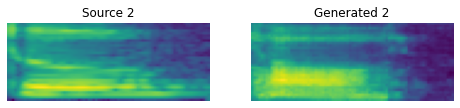

  4%|▍         | 90/2000 [00:00<00:03, 607.06it/s, loss=0.000945, spectral_convergence=-10.7]

(3979, 1)
(16, 32, 8, 1)
Generating...
Assembling and Converting...


100%|██████████| 2000/2000 [00:03<00:00, 589.41it/s, loss=0.00016, spectral_convergence=-14.8]


Saving...
Saved WAV!


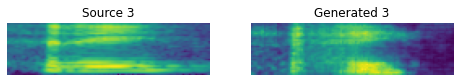

  2%|▏         | 30/2000 [00:00<00:04, 465.81it/s, loss=0.0202, spectral_convergence=-1.21]

(3491, 1)
(14, 32, 8, 1)
Generating...
Assembling and Converting...


100%|██████████| 2000/2000 [00:03<00:00, 603.87it/s, loss=0.00154, spectral_convergence=-18.8]


Saving...
Saved WAV!


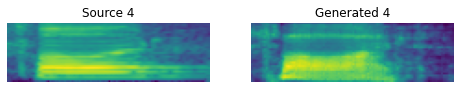

  4%|▍         | 90/2000 [00:00<00:03, 580.48it/s, loss=0.00264, spectral_convergence=-13.4]

(4480, 1)
(18, 32, 8, 1)
Generating...
Assembling and Converting...


100%|██████████| 2000/2000 [00:03<00:00, 559.31it/s, loss=0.00243, spectral_convergence=-17.3]


Saving...
Saved WAV!


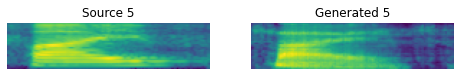

  1%|          | 20/2000 [00:00<00:05, 376.68it/s, loss=0.0035, spectral_convergence=-1.49] 

(4155, 1)
(17, 32, 8, 1)
Generating...
Assembling and Converting...


100%|██████████| 2000/2000 [00:03<00:00, 575.58it/s, loss=0.000212, spectral_convergence=-19.4]


Saving...
Saved WAV!


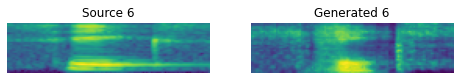

  0%|          | 10/2000 [00:00<00:07, 257.74it/s, loss=0.0138, spectral_convergence=-.128]

(5131, 1)
(21, 32, 8, 1)
Generating...
Assembling and Converting...


100%|██████████| 2000/2000 [00:03<00:00, 534.69it/s, loss=0.00239, spectral_convergence=-16.8]


Saving...
Saved WAV!


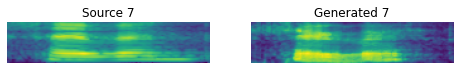

  4%|▍         | 80/2000 [00:00<00:03, 578.58it/s, loss=0.009, spectral_convergence=-6.33] 

(4222, 1)
(17, 32, 8, 1)
Generating...
Assembling and Converting...


100%|██████████| 2000/2000 [00:03<00:00, 542.47it/s, loss=0.0018, spectral_convergence=-16.9]


Saving...
Saved WAV!


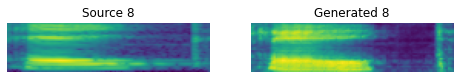

  4%|▍         | 80/2000 [00:00<00:03, 563.91it/s, loss=0.000306, spectral_convergence=-16.5]

(4189, 1)
(17, 32, 8, 1)
Generating...
Assembling and Converting...


100%|██████████| 2000/2000 [00:03<00:00, 551.66it/s, loss=0.000644, spectral_convergence=-16.2]


Saving...
Saved WAV!


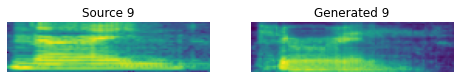

In [29]:
#Wav to wav conversion

# wv, sr = librosa.load(librosa.util.example_audio_file(), sr=16000)  #Load waveform
# ls = glob(f'{recording_dir}/*.wav')
for k in range(10):
# k = 9
    wv, sr = x, sr = tf.audio.decode_wav(tf.io.read_file(recording_dir + "/" + str(k) + "_george_0.wav"), 1)
    wv = np.array(wv, dtype=np.float32)
    print(wv.shape)
    speca = prep(wv)                                                    #Waveform to Spectrogram

    # plt.figure(figsize=(50,1))                                          #Show Spectrogram
    # plt.imshow(np.flip(speca, axis=0), cmap=None)
    # plt.axis('off')
    # plt.show()

    abwv = towave(speca, name='Translation'+str(k), num=k, path=result_dir,show=True)           #Convert and save wav
    # specab = prep(abwv)
    # plt.figure(figsize=(50,1))                                          #Show Spectrogram
    # plt.imshow(np.flip(specab, axis=0), cmap=None)
    # plt.axis('off')
    # plt.show()